# Notebook dedicated to construct the test dataset of solar Nue and 208Tl events

Convention to define the size of train and test data set: The last two files in the list of directories of .root files are for test

In [1]:
import numpy as np
import pandas as pd
import random

import glob
import re
import os

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Useful Functions

In [7]:
def magnitude(vector): 
    #Function to Compute the radial position of events
    x = vector[:,0]
    y = vector[:,1]
    z = vector[:,2]

    r = np.sqrt(x**2 + y**2 + z**2)
    r = r.astype(np.float32)
    return r

# Load Numpy files

In [12]:
# ============ Data Cuts Settings ============
energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20 #Nhits cut to be applied after the time residual cuts


In [6]:
main_dir = f'E:/Data/solars/mc/ML Data/np_arrays/Test/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
solar_fpattern = 'SolarNue_'
tl208_fpattern = '208Tl_'

observable_name = ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual', 'hit_pmtQHS']

solar_dict = {var_i: np.array([]) for var_i in observable_name}
tl208_dict = {var_i: np.array([]) for var_i in observable_name}

#Load each varibles within a loop of variables and fill the dictionaries
#Loop over var names
for var_i in observable_name:
    #create flist for the multiple var_i observables (exm: evID_0, evID_1, ...)
    solar_var_i_flist = glob.glob(main_dir + solar_fpattern + var_i + '*.npy')
    tl208_var_i_flist = glob.glob(main_dir + tl208_fpattern + var_i + '*.npy')

    #Loop over flist:
    for solar_file_i in solar_var_i_flist:
        load_solar_var_i = np.load(solar_file_i)
        solar_dict[var_i] = np.append(solar_dict[var_i], load_solar_var_i)

    for tl208_file_i in tl208_var_i_flist:
        load_208tl_var_i = np.load(tl208_file_i)
        tl208_dict[var_i] = np.append(tl208_dict[var_i], load_208tl_var_i)

## Remove Redundant Values

In [ ]:
#Extract the redundant evID
solar_evID = solar_dict['evtid']
tl208_evID = tl208_dict['evtid']

redundant_observables_name = ['evtid', 'posr', 'energy'] #List of observables with redundant values to cut

# Empty lists which will contain the non-repeated values of the observables for singles events
solar_dict_ev = {var_i: [] for var_i in redundant_observables_name}
tl208_dict_ev = {var_i: [] for var_i in redundant_observables_name}

#evID index break list
solar_data_break_i = [0]  #array whose elements are the index from where an event start and end.
tl208_data_break_i = [0]

solar_N_data = len(solar_evID)
tl208_N_data = len(tl208_evID)

print('Looking for break index in solars evID')
for i_dx in range(solar_N_data - 1):
    if solar_evID[i_dx] != solar_evID[i_dx+1]:
        solar_data_break_i.append(i_dx+1)

print('Looking for break index in 208Tl evID')
for i_dx in range(tl208_N_data - 1):
    if tl208_evID[i_dx] != tl208_evID[i_dx+1]:
        tl208_data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
solar_data_break_i.append(solar_N_data - 1)
tl208_data_break_i.append(tl208_N_data - 1)

N_solar_terms = len(solar_data_break_i)
N_tl208_terms = len(tl208_data_break_i)

#Start to save the non-redundant values and separate the time residuals and angles for each event
#Solar Loop
print(f'saving the non-redundant values for solars')
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    for var_i in redundant_observables_name:
        non_redundant_var_i_value = solar_dict[var_i][init_i : final_i][0]
        solar_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
print('Transforming solars to np.array')
for var_i in redundant_observables_name:
    solar_dict_ev[var_i] = np.array(solar_dict_ev[var_i])

#Now append the per hit observables
solar_dict_ev['cos_alpha'] = solar_dict['cos_alpha']
solar_dict_ev['hit_residual'] = solar_dict['hit_residual']
solar_dict_ev['hit_pmtQHS'] = solar_dict['hit_pmtQHS']

#208Tl Loop
print('Transforming 208Tl to np.array')
print(f'saving the non-redundant values for 208Tl')
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]

    for var_i in redundant_observables_name:
        non_redundant_var_i_value = tl208_dict[var_i][init_i : final_i][0]
        tl208_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
for var_i in redundant_observables_name:
    tl208_dict_ev[var_i] = np.array(tl208_dict_ev[var_i])

#Now append the per hit observables
tl208_dict_ev['cos_alpha'] = tl208_dict['cos_alpha']
tl208_dict_ev['hit_residual'] = tl208_dict['hit_residual']
tl208_dict_ev['hit_pmtQHS'] = tl208_dict['hit_pmtQHS']

Looking for break index in solars evID
Looking for break index in 208Tl evID
saving the non-redundant values for solars


## NHits Cut: Select only events that verify nhits >= nhits_cut within the $\Delta$ window

In [14]:
# ========= nhits cut on Solar Data =========
solar_energy = solar_dict_ev['energy']
solar_posr = solar_dict_ev['posr']
solar_hit_residual = solar_dict_ev['hit_residual']
solar_cos_alpha = solar_dict_ev['cos_alpha']

solar_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
solar_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
solar_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    solar_cos_alpha_ev_i = solar_cos_alpha[init_i:final_i]
    solar_hit_residual_ev_i = solar_hit_residual[init_i:final_i]
    nhits_ev_i = len(solar_cos_alpha_ev_i)

    solar_cos_alpha_ev.append(solar_cos_alpha_ev_i)
    solar_time_residual_ev.append(solar_hit_residual_ev_i)
    solar_nhits.append(nhits_ev_i)
solar_nhits = np.array(solar_nhits)

#Selection of Events
nhits_condition = (solar_nhits >= nhits_cut)

solar_energy = solar_energy[nhits_condition]
solar_posr = solar_posr[nhits_condition]
solar_cos_alpha_ev = [arr for arr, cond in zip(solar_cos_alpha_ev, nhits_condition) if cond]
solar_time_residual_ev = [arr for arr, cond in zip(solar_time_residual_ev, nhits_condition) if cond]

# ========= nhits cut on 208Tl =========
tl208_energy = tl208_dict_ev['energy']
tl208_posr = tl208_dict_ev['posr']
tl208_hit_residual = tl208_dict_ev['hit_residual']
tl208_cos_alpha = tl208_dict_ev['cos_alpha']

tl208_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
tl208_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
tl208_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]
    
    tl208_cos_alpha_ev_i = tl208_cos_alpha[init_i:final_i]
    tl208_hit_residual_ev_i = tl208_hit_residual[init_i:final_i]
    nhits_ev_i = len(tl208_cos_alpha_ev_i)

    tl208_cos_alpha_ev.append(tl208_cos_alpha_ev_i)
    tl208_time_residual_ev.append(tl208_hit_residual_ev_i)
    tl208_nhits.append(nhits_ev_i)
tl208_nhits = np.array(tl208_nhits)

#Selection of Events
nhits_condition = (tl208_nhits >= nhits_cut)

tl208_energy = tl208_energy[nhits_condition]
tl208_posr = tl208_posr[nhits_condition]
tl208_cos_alpha_ev = [arr for arr, cond in zip(tl208_cos_alpha_ev, nhits_condition) if cond]
tl208_time_residual_ev = [arr for arr, cond in zip(tl208_time_residual_ev, nhits_condition) if cond]

### Verify Plots

<Axes: ylabel='Count'>

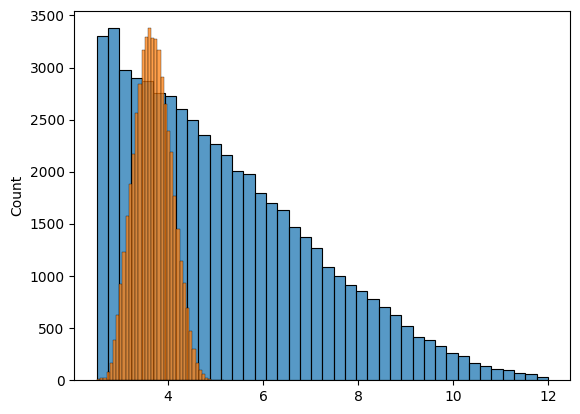

In [15]:
sn.histplot(solar_energy, bins = 40)
sn.histplot(tl208_energy, bins = 40)

<Axes: ylabel='Count'>

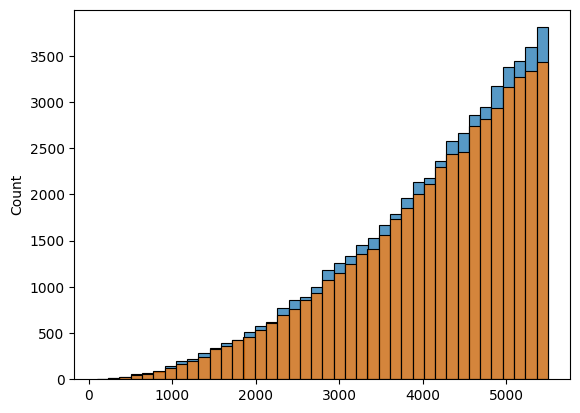

In [16]:
sn.histplot(solar_posr, bins = 40)
sn.histplot(tl208_posr, bins = 40)

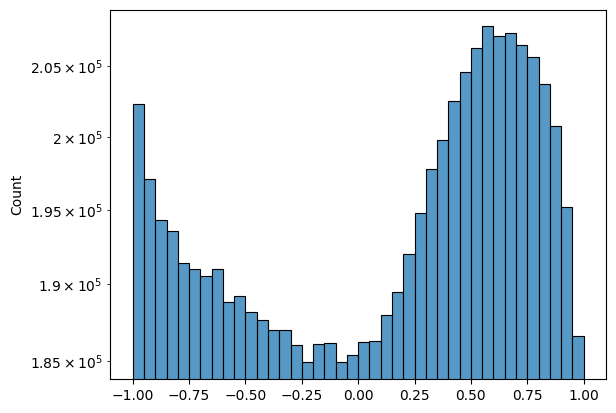

In [17]:
sn.histplot(solar_cos_alpha, bins = 40)
plt.yscale('log')

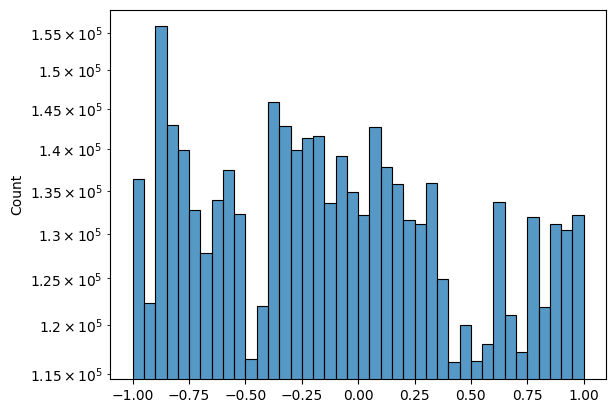

In [18]:
sn.histplot(tl208_cos_alpha, bins = 40)
plt.yscale('log')

<Axes: ylabel='Count'>

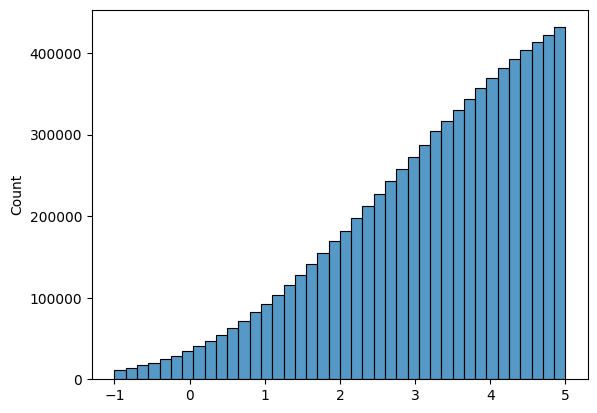

In [19]:
sn.histplot(solar_hit_residual, bins = 40)

<Axes: ylabel='Count'>

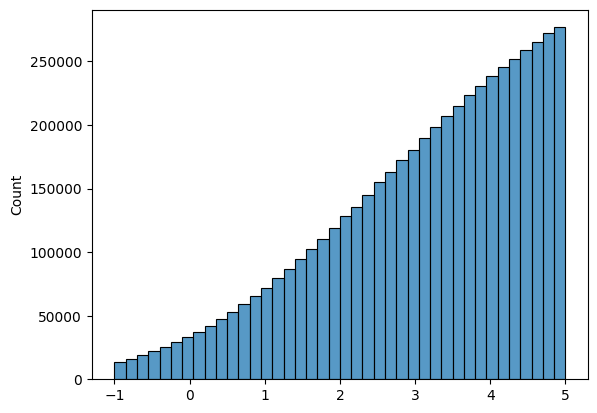

In [20]:
sn.histplot(tl208_hit_residual, bins = 40)

# Dataset Construction

## Solar Nue Dataset

### Features Construction: Pixels and Labels

In [21]:
image_dim = (10,10)
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)

H_flaten_nu = []  #flatten images of solar nu evs with shape (n_samples, bins x bins)
labels_nu = []  #save label of solar nu evs as [1,0]

N_evs = len(solar_cos_alpha_ev)

for i_dx in range(N_evs):

    solar_time_res_ev_i = solar_time_residual_ev[i_dx]
    solar_cos_ev_i = solar_cos_alpha_ev[i_dx]

    #raw histogram
    bins = image_dim[0]
    H_nu_ev, _, _ = np.histogram2d(x = solar_cos_ev_i, y = solar_time_res_ev_i, bins = [bins, bins], range = [range_cos, range_time])
    #normalization by NHits within slice of cos_alpha
    sum_hit_nu_ev = np.sum(H_nu_ev,axis=0)
    H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev
    H_nu_ev_norm = np.nan_to_num(H_nu_ev_norm, nan = 0.0)

    H_flatten_ev = H_nu_ev_norm.ravel()
    H_flaten_nu.append(np.array(H_flatten_ev))
    labels_nu.append([1,0])
    
H_flaten_nu = np.array(H_flaten_nu)
labels_nu = np.array(labels_nu)

C:\Users\joanc\AppData\Local\Temp\ipykernel_412\1040089279.py:20: RuntimeWarning: invalid value encountered in divide
  H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev


In [22]:
H_flaten_nu.shape

(54798, 100)

In [23]:
labels_nu.shape

(54798, 2)

### Verify the Images

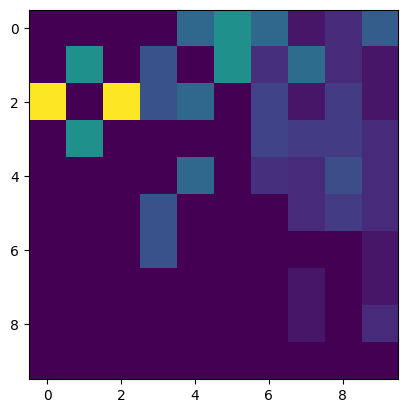

In [24]:
#High Stat
ev_i = 6
H_single_ev = H_flaten_nu[ev_i].reshape(bins, bins)
plt.imshow(H_single_ev)

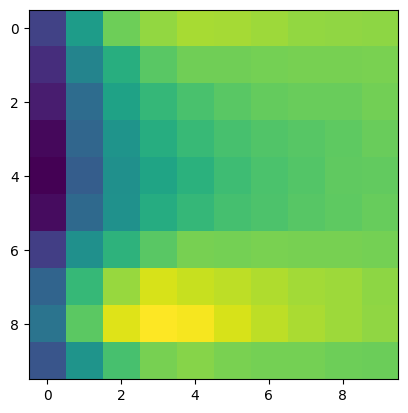

In [35]:
#High Stat
H_high_stat = np.sum(H_flaten_nu, axis = 0)
H_high_stat = H_high_stat.reshape(bins, bins)
plt.imshow(H_high_stat)

### Pandas Dataframe

In [26]:
df_solar_data = {}

N_pixel = bins*bins
for j in range(N_pixel):
    pixel_i = H_flaten_nu[:, j]
    df_solar_data['pixel_'+str(j)] = pixel_i

df_solar_data['energy (MeV)'] = solar_energy
df_solar_data['radius (mm)'] = solar_posr
df_solar_data['IsNu'] = labels_nu[:,0]
df_solar_data['IsTl'] = labels_nu[:,1]

df_solar_data = pd.DataFrame(df_solar_data)

In [27]:
df_solar_data

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
0,0.0,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,...,0.000000,0.000000,0.200000,0.100000,0.000000,0.100000,3.255294,1987.190552,1,0
1,0.0,0.50,0.125000,0.2000,0.150000,0.500000,0.400000,0.137931,0.218750,0.230769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,4.910982,4580.352051,1,0
2,0.0,0.00,0.142857,0.0000,0.000000,0.045455,0.074074,0.040000,0.054054,0.064516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.644320,5410.730469,1,0
3,0.0,0.00,0.000000,0.0000,0.000000,0.000000,0.035714,0.050000,0.022222,0.025000,...,0.066667,0.058824,0.071429,0.025000,0.088889,0.100000,7.901709,5215.486328,1,0
4,0.0,0.00,0.000000,0.0000,0.666667,0.000000,0.600000,0.190476,0.333333,0.181818,...,0.000000,0.000000,0.000000,0.047619,0.000000,0.090909,3.773207,2873.001221,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54793,0.0,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.133333,0.000000,0.043478,...,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,3.139037,4057.926270,1,0
54794,0.0,0.00,0.000000,1.0000,0.600000,0.571429,0.285714,0.285714,0.285714,0.107143,...,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,6.083028,2273.144287,1,0
54795,0.0,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.033333,0.035714,...,0.000000,0.076923,0.000000,0.076923,0.266667,0.071429,5.330648,3446.552490,1,0
54796,1.0,0.25,0.000000,0.0625,0.000000,0.068966,0.150000,0.095238,0.062500,0.054545,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,8.313311,4473.042969,1,0


## 208Tl Dataset

### Features Construction: Pixels and Labels

In [29]:
image_dim = (10,10)
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)

H_flaten_tl = []  #flatten images of 208Tl nu evs with shape (n_samples, bins x bins)
labels_tl = []  #save label of solar nu evs as [0,1]

N_evs = len(tl208_cos_alpha_ev)

for i_dx in range(N_evs):

    tl208_time_res_ev_i = tl208_time_residual_ev[i_dx]
    tl208_cos_ev_i =  tl208_cos_alpha_ev[i_dx]

    #raw histogram
    bins = image_dim[0]
    H_tl_ev, _, _ = np.histogram2d(x = tl208_cos_ev_i, y =  tl208_time_res_ev_i, bins = [bins, bins], range = [range_cos, range_time])
    #normalization by NHits within slice of cos_alpha
    sum_hit_tl_ev = np.sum(H_tl_ev,axis=0)
    H_tl_ev_norm = H_tl_ev/sum_hit_tl_ev
    H_tl_ev_norm = np.nan_to_num(H_tl_ev_norm, nan = 0.0)

    H_flatten_ev = H_tl_ev_norm.ravel()
    H_flaten_tl.append(np.array(H_flatten_ev))
    labels_tl.append([0, 1])
    
H_flaten_tl = np.array(H_flaten_tl)
labels_tl = np.array(labels_tl)

C:\Users\joanc\AppData\Local\Temp\ipykernel_412\4015640549.py:20: RuntimeWarning: invalid value encountered in divide
  H_tl_ev_norm = H_tl_ev/sum_hit_tl_ev


In [30]:
H_flaten_tl.shape

(51337, 100)

In [31]:
labels_tl.shape

(51337, 2)

### Verify the Images

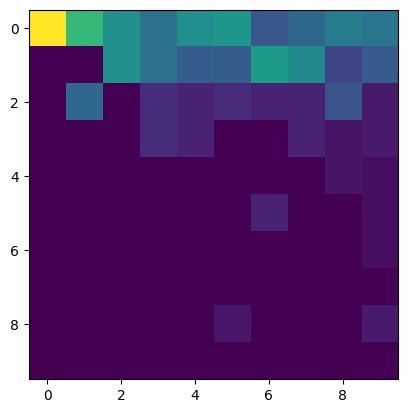

In [32]:
#High Stat
ev_i = 10
H_single_ev = H_flaten_tl[ev_i].reshape(bins, bins)
plt.imshow(H_single_ev)

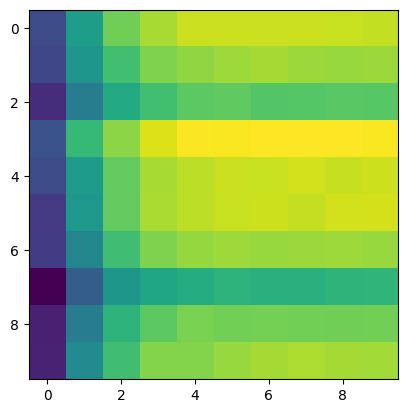

In [37]:
#High Stat
H_high_stat = np.sum(H_flaten_tl, axis = 0)
H_high_stat = H_high_stat.reshape(bins, bins)
plt.imshow(H_high_stat)

### Pandas Dataframe

In [38]:
df_tl208_data = {}

N_pixel = bins*bins
for j in range(N_pixel):
    pixel_i = H_flaten_tl[:, j]
    df_tl208_data['pixel_'+str(j)] = pixel_i

df_tl208_data['energy (MeV)'] = tl208_energy
df_tl208_data['radius (mm)'] = tl208_posr
df_tl208_data['IsNu'] = labels_tl[:,0]
df_tl208_data['IsTl'] = labels_tl[:,1]

df_tl208_data = pd.DataFrame(df_tl208_data)

In [39]:
df_tl208_data

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
0,1.0,0.0,0.400000,0.555556,0.000000,0.500000,0.176471,0.375000,0.100000,0.214286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.149020,4387.667969,0,1
1,0.0,1.0,0.000000,0.000000,0.400000,0.111111,0.285714,0.200000,0.142857,0.142857,...,0.000000,0.000000,0.142857,0.066667,0.000000,0.000000,4.320164,2764.875977,0,1
2,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.111111,0.000000,0.428571,0.090909,...,0.000000,0.000000,0.222222,0.333333,0.142857,0.000000,3.423914,964.343750,0,1
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.400000,0.148148,0.272727,...,0.000000,0.000000,0.066667,0.000000,0.037037,0.000000,3.833767,2697.529785,0,1
4,0.0,0.0,0.250000,0.200000,0.000000,0.272727,0.250000,0.000000,0.043478,0.095238,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.095238,3.518195,3802.082764,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51332,0.0,0.5,0.571429,0.777778,0.545455,0.846154,0.461538,0.294118,0.545455,0.375000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.916830,5193.389160,0,1
51333,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,...,0.153846,0.100000,0.000000,0.086957,0.062500,0.173913,3.087799,4563.249512,0,1
51334,0.0,0.0,0.250000,0.000000,0.153846,0.000000,0.071429,0.000000,0.142857,0.034483,...,0.000000,0.000000,0.000000,0.047619,0.000000,0.034483,3.976594,4155.316895,0,1
51335,0.0,0.0,0.000000,0.000000,0.285714,0.100000,0.000000,0.000000,0.125000,0.076923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,4.255462,3443.718994,0,1


## Unify Solar_Nue and 208Tl Datasets

In [41]:
save = True
save_dir = 'E:/Data/solars/mc/ML Data/Test/pd_dataframe/'
fname = f'df_Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

df = pd.concat([df_solar_data, df_tl208_data], ignore_index=True)

if save:
    df.to_csv(save_dir + fname, index=False)
    
df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,...,0.000000,0.000000,0.200000,0.100000,0.000000,0.100000,3.255294,1987.190552,1,0
1,0.0,0.5,0.125000,0.200000,0.150000,0.500000,0.400000,0.137931,0.218750,0.230769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,4.910982,4580.352051,1,0
2,0.0,0.0,0.142857,0.000000,0.000000,0.045455,0.074074,0.040000,0.054054,0.064516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.644320,5410.730469,1,0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.035714,0.050000,0.022222,0.025000,...,0.066667,0.058824,0.071429,0.025000,0.088889,0.100000,7.901709,5215.486328,1,0
4,0.0,0.0,0.000000,0.000000,0.666667,0.000000,0.600000,0.190476,0.333333,0.181818,...,0.000000,0.000000,0.000000,0.047619,0.000000,0.090909,3.773207,2873.001221,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106130,0.0,0.5,0.571429,0.777778,0.545455,0.846154,0.461538,0.294118,0.545455,0.375000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.916830,5193.389160,0,1
106131,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,...,0.153846,0.100000,0.000000,0.086957,0.062500,0.173913,3.087799,4563.249512,0,1
106132,0.0,0.0,0.250000,0.000000,0.153846,0.000000,0.071429,0.000000,0.142857,0.034483,...,0.000000,0.000000,0.000000,0.047619,0.000000,0.034483,3.976594,4155.316895,0,1
106133,0.0,0.0,0.000000,0.000000,0.285714,0.100000,0.000000,0.000000,0.125000,0.076923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,4.255462,3443.718994,0,1
